# A quick trial to embed Xarry into ASDF

#### Author:  Yiyu Ni
#### Email: niyiyu@uw.edu
#### Last update: Aug. 26, 2021

Ok, first import everything we need here. You could see there's a CloudPyASDF module.  This is still being worked on.

In [1]:
import sys
sys.path.append("../")

import sliderule
import xarray
import numpy as np
import pyasdf
import h5py
import matplotlib.pyplot as plt

from CloudPyASDF.utils import read_dict, readp_dict, readp_array, dump_group_dict
from CloudPyASDF.xarray_helper import embed_xarray

Usually, xarray parse netCDF file, which generally can not be read/write directly from/into HDF5 (there's some version and specification problem). The dataset comtains three dimension: lat, lon and time, which is most case when using Xarray I guess.

Note how data/coordinates are stored as mesh in this type of dataset. Also note that, for each data as well as the entire Dataset has some attributes associated with itself. I don't want to miss them.

In [3]:
ds = xarray.open_dataset('../testfile/example.nc4')
ds

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
ds['time'].data.dtype

dtype('<M8[ns]')

Now, we're creating a clean ASDF file, which contians no data at all.

In [5]:
asdf = pyasdf.ASDFDataSet("../testfile/ASDF_with_Xarray.h5")
del asdf

And use some functions imported, we stored the entire xarray data into a group/dataset structure in a HDF5 file.

In [4]:
h5ds = h5py.File("../testfile/ASDF_with_Xarray.h5", mode = "a")
embed_xarray(ds, h5ds['/Waveforms'])
dump_group_dict(h5ds['/AuxiliaryData/XR'], 'XRTDict')
h5ds.close()

Now, the ASDF file looks like this. Note how XR are dissolved into several parts.
```
HDF5 "ASDF_with_Xarray.h5" {
FILE_CONTENTS {
 group      /
 group      /AuxiliaryData
 group      /AuxiliaryData/XR
 dataset    /AuxiliaryData/XR/XRDict
 dataset    /AuxiliaryData/XR/attrs
 group      /AuxiliaryData/XR/coords
 group      /AuxiliaryData/XR/coords/lat
 dataset    /AuxiliaryData/XR/coords/lat/attrs
 dataset    /AuxiliaryData/XR/coords/lat/data
 group      /AuxiliaryData/XR/coords/lon
 dataset    /AuxiliaryData/XR/coords/lon/attrs
 dataset    /AuxiliaryData/XR/coords/lon/data
 group      /AuxiliaryData/XR/coords/time
 dataset    /AuxiliaryData/XR/coords/time/attrs
 dataset    /AuxiliaryData/XR/coords/time/data
 group      /AuxiliaryData/XR/data_vars
 group      /AuxiliaryData/XR/data_vars/air
 dataset    /AuxiliaryData/XR/data_vars/air/attrs
 dataset    /AuxiliaryData/XR/data_vars/air/data
 dataset    /AuxiliaryData/XR/dims
 group      /Provenance
 group      /Waveforms
 }
}
```

OK. I've tried to store Xarray into ASDF. Now let's read them with h5coro. Here for simplicity, the data is stored locally, and performance has not been considered. So there should be much to improve for this draft.

Similar way to initialize h5file object:

In [5]:
resource = "ASDF_with_Xarray.h5"
format = "file"
path = "../testfile/"
region = ""
endpoint = ""
h5file = sliderule.h5coro(resource, format, path, region, endpoint)

I admit that the parsing work looks messy. It can be improved later!

In [6]:
path = '/AuxiliaryData/XR/'

# First to read is the XRDict that descirbe the xarray structure. 
# Here I assumed xarray comtains attributes and dimensions, and use multi-thread reading.
# But it may not be the case in the future.
readp_list = []
for _i in ["XRDict", "attrs", "dims"]:
    readp_list.append([ _i, 0, 0, -1])
_pdict = readp_dict(h5file, readp_list, path)
_XR = _pdict['XRDict']['XR']
_attrs = _pdict['attrs']
_dims = _pdict['dims']

# Also read the dataset waiting for xarray parsing.
dataset = {}
for _k, _i in _XR['data_vars'].items():
    dataset.update({
        _k:(
            _dims.keys(),                                                 # Coordinates
            np.array(h5file.read(path + "data_vars/" + _k + "/data")).reshape(
                list(_dims.values())),                                    # Datas
            read_dict(h5file, path + "data_vars/" + _k + "/attrs")        # Attributes
        )
    })

# ... and also the coordinates part.
readp_list = [[_k, 0, 0, -1] for _k in _XR['coords'].keys()]
coords_array = readp_array(h5file, readp_list, path + 'coords/', '/data')
coords_attrs = readp_dict(h5file, readp_list, path + 'coords/', '/attrs')
coords = {}
for _k in _XR['coords'].keys():
    coords.update({
        _k: (_k, coords_array[_k], coords_attrs[_k])
    })

The rest would be easy. Use all variable above, conform to Xarray initialization regulation, and create the xarray.Dataset. Note that time convection may be required as it is stored as float32 in HDF5.

In [7]:
xds = xarray.Dataset(dataset, 
                     attrs = _pdict['attrs'],
                     coords = coords)
xds['time'] = xds['time'].astype('datetime64[ns]')
xds

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lon      (lon) float64 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * lat      (lat) float64 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
Data variables:
    air      (time, lat, lon) float64 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

OK. Randomly choose some data. Looks pretty good.

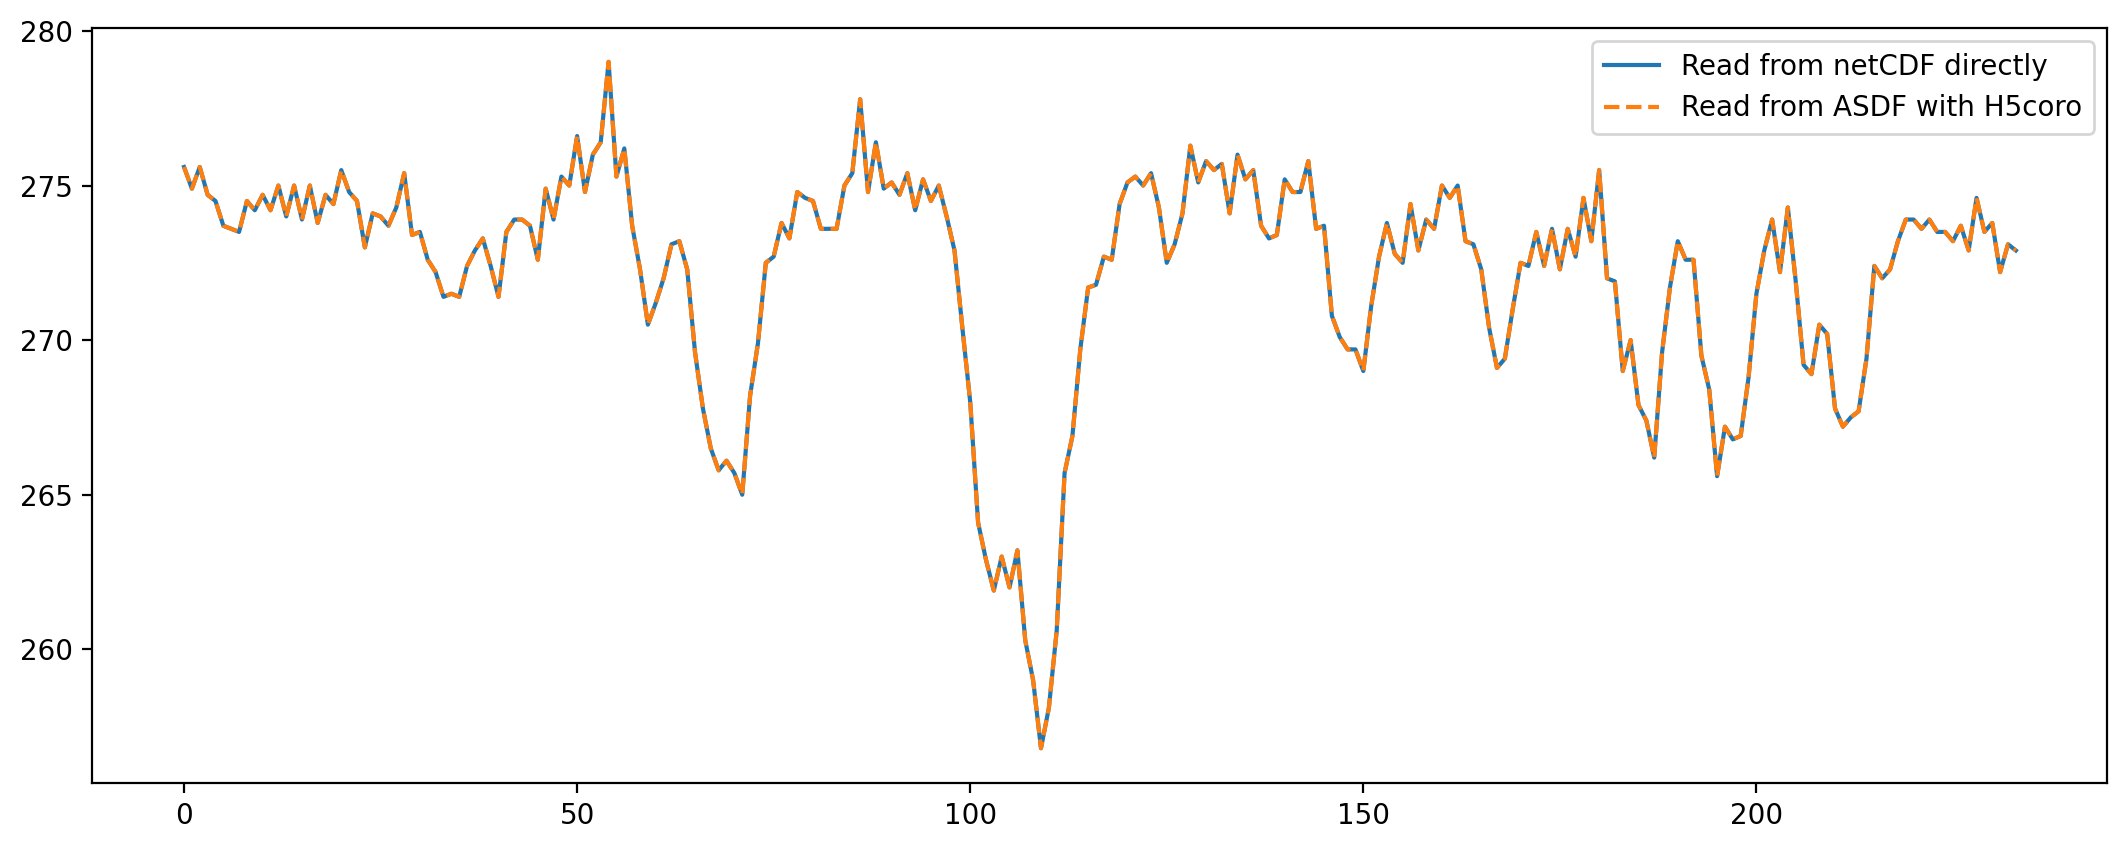

In [10]:
plt.figure(figsize = (13, 5), dpi = 200)
plt.plot(ds['air'].loc[:'2013-2-28T06:00:00.000000000',60, 210].data, '-', label = 'Read from netCDF directly')
plt.plot(xds['air'].loc[:'2013-2-28T06:00:00.000000000',60, 210].data, '--', label = 'Read from ASDF with H5coro')
plt.legend()